# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import zipfile

from tqdm import tqdm
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

from utils.wandb_utils import CRLRunCollector
from utils.create_zip import save_loop
from utils.preprocessing import load_zip, bootstrap

np.random.seed(42)

To use this code:
* Label your Wandb runs with tags
* Update the following three cells

If you already have a zip file (either the data we have cached or data you have
constructed yourself), you can set `wandb_collect = False`, which will skip the 
`RunCollector`-related cells. Otherwise, you will need to have a `RunCollector`.

In [43]:
path = 'gym_sweep'  # name of your cached RunCollector and zip file

return_key = 'episode/return'
logging_freq = 1000  # Wandb logging frequency in steps

# Maximum possible returns (estimated with infinite data and compute) on each
# environment. These are mostly eyeballed such that runs reach 80% (hence
# the 1.25 multiplier) but not 90%. There is some variation for different environments.
max_returns = {
    "HalfCheetah-v4": 7300 * 1.25,
    "Walker2d-v4": 4000 * 1.25,
    "Ant-v4": 5300 * 1.25,
    "Humanoid-v4": 5200 * 1.25,
}

thresholds = [100, 200, 300, 400, 500, 600, 700, 800]  # out of 1000

predicted_utds = [0.25, 0.5, 1, 2, 4, 8, 16]  # UTDs to include for linear fit prediction

wandb_collect = True
assert wandb_collect or os.path.exists(f'cache/zip/{path}.zip')

In [47]:
if wandb_collect:
    collector_cls = CRLRunCollector
    wandb_project = 'prestonfu/crl'
    wandb_tags = ['sac_grid_manual_250206']  # Wandb tags to include
    wandb_update_baseline_tag = 'sac_grid_250207_bl'  # set to falsey to not update tags on existing runs
    
    gym_sweep_collector = collector_cls(wandb_project).create(
        load=True,
        tags=wandb_tags,
        path=f'cache/collector/{path}.npy',
        parallel=True
    )

    collector = gym_sweep_collector

    # Drop runs that do not go for the full number of steps and extra runs beyond desired number of seeds
    num_seeds = 8
    collector.remove_short(0.95)
    collector.trim(num_seeds, verbose=True)

In [5]:
if wandb_collect:
    save_loop(collector, return_key, path, logging_freq=1000)   # Remove logging_freq to save all data
    os.makedirs('cache/zip', exist_ok=True)
    subprocess.run(f"zip -r {path}.zip {path} && mv {path}.zip ../zip", shell=True, check=True, cwd='cache/data')

# Preprocessing

In [6]:
gym_grid_search_df, (envs, utds, batch_sizes, learning_rates) = load_zip(f'cache/zip/{path}.zip', max_returns, thresholds)
gym_grid_search_df = bootstrap(gym_grid_search_df, thresholds)

  6%|▌         | 8/144 [00:00<00:10, 12.95it/s]

 11%|█         | 16/144 [00:01<00:09, 13.33it/s]/home/preston/miniconda3/envs/crl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 18%|█▊        | 26/144 [00:02<00:09, 12.12it/s]/home/preston/miniconda3/envs/crl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 19%|█▉        | 28/144 [00:02<00:09, 12.02it/s]/home/preston/miniconda3/envs/crl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 22%|██▏       | 32/144 [00:02<00:09, 11.83it/s]/home/preston/miniconda3/envs/crl/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dty

Average standard deviation across all conditions: 2771.15


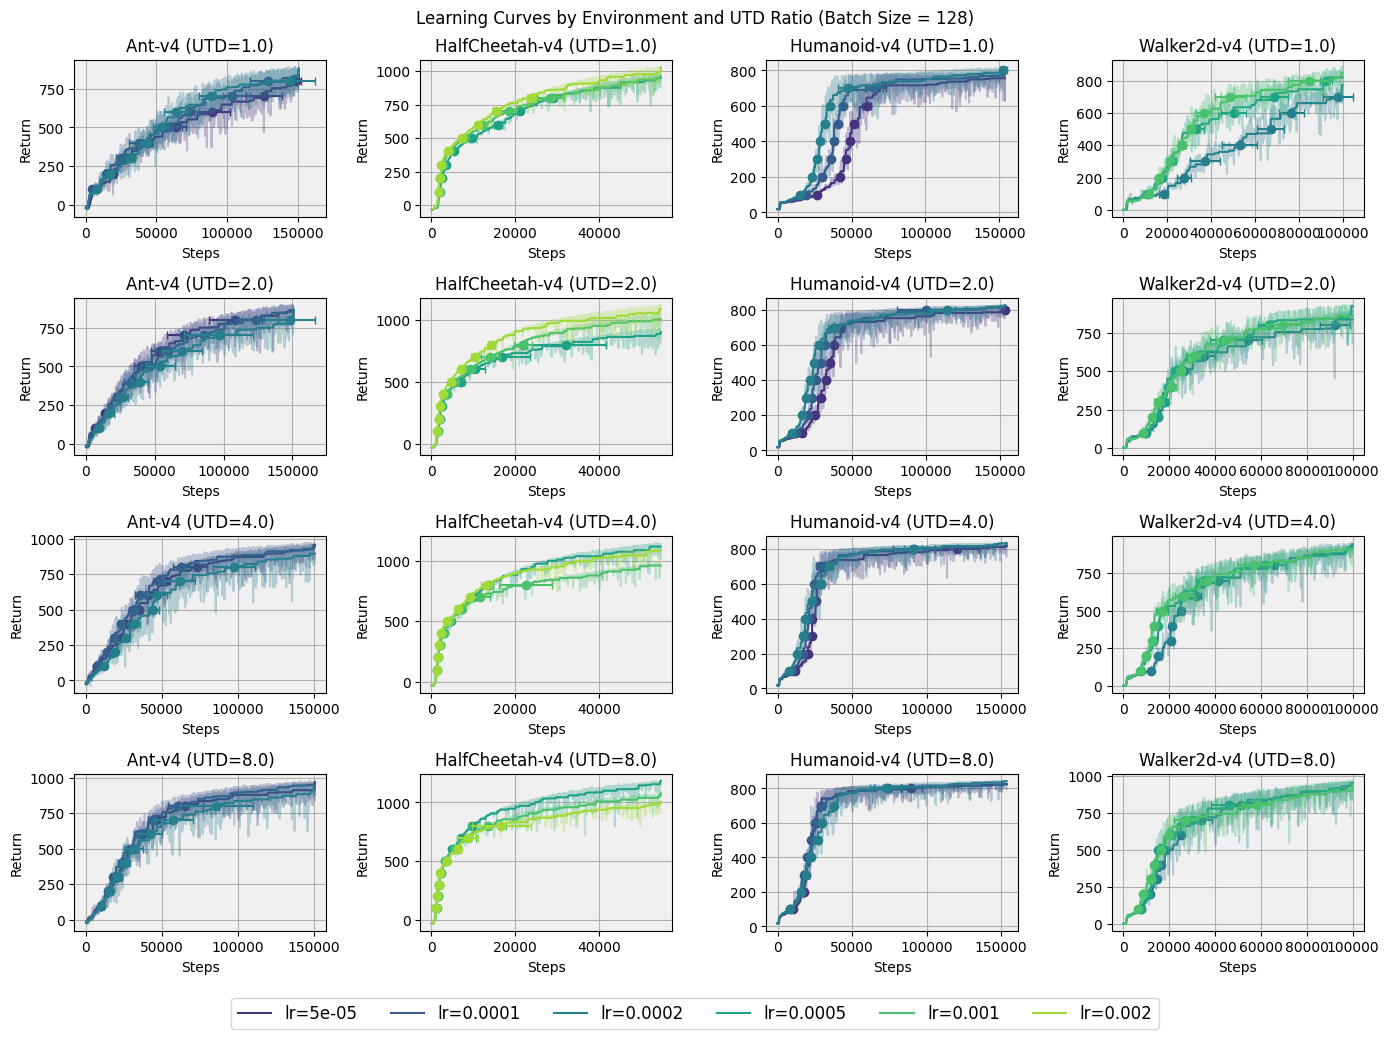

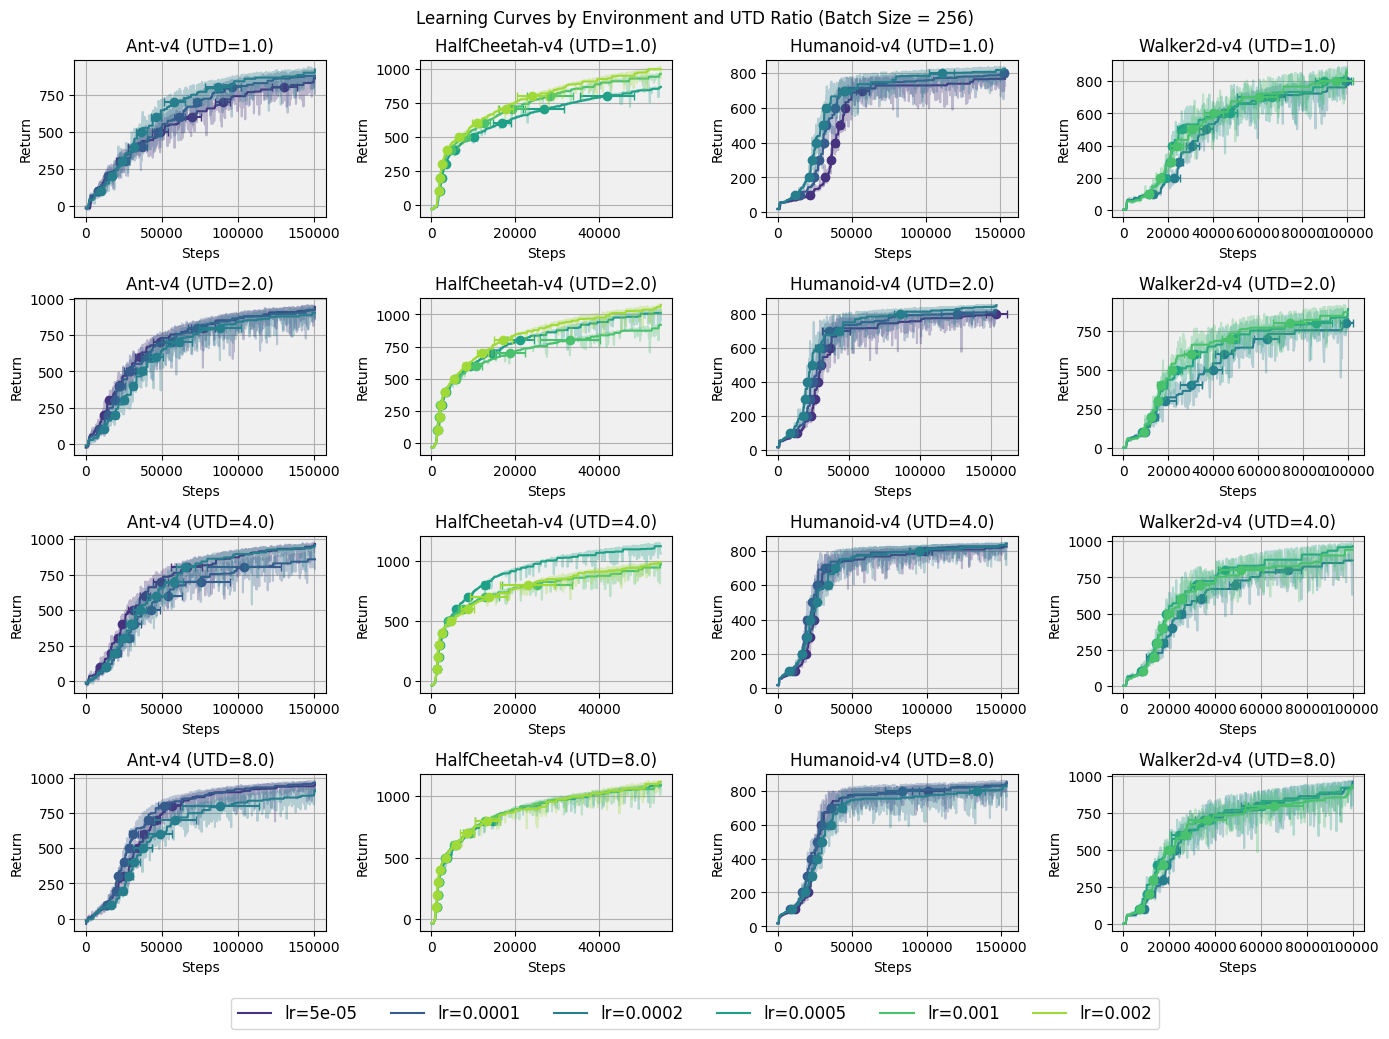

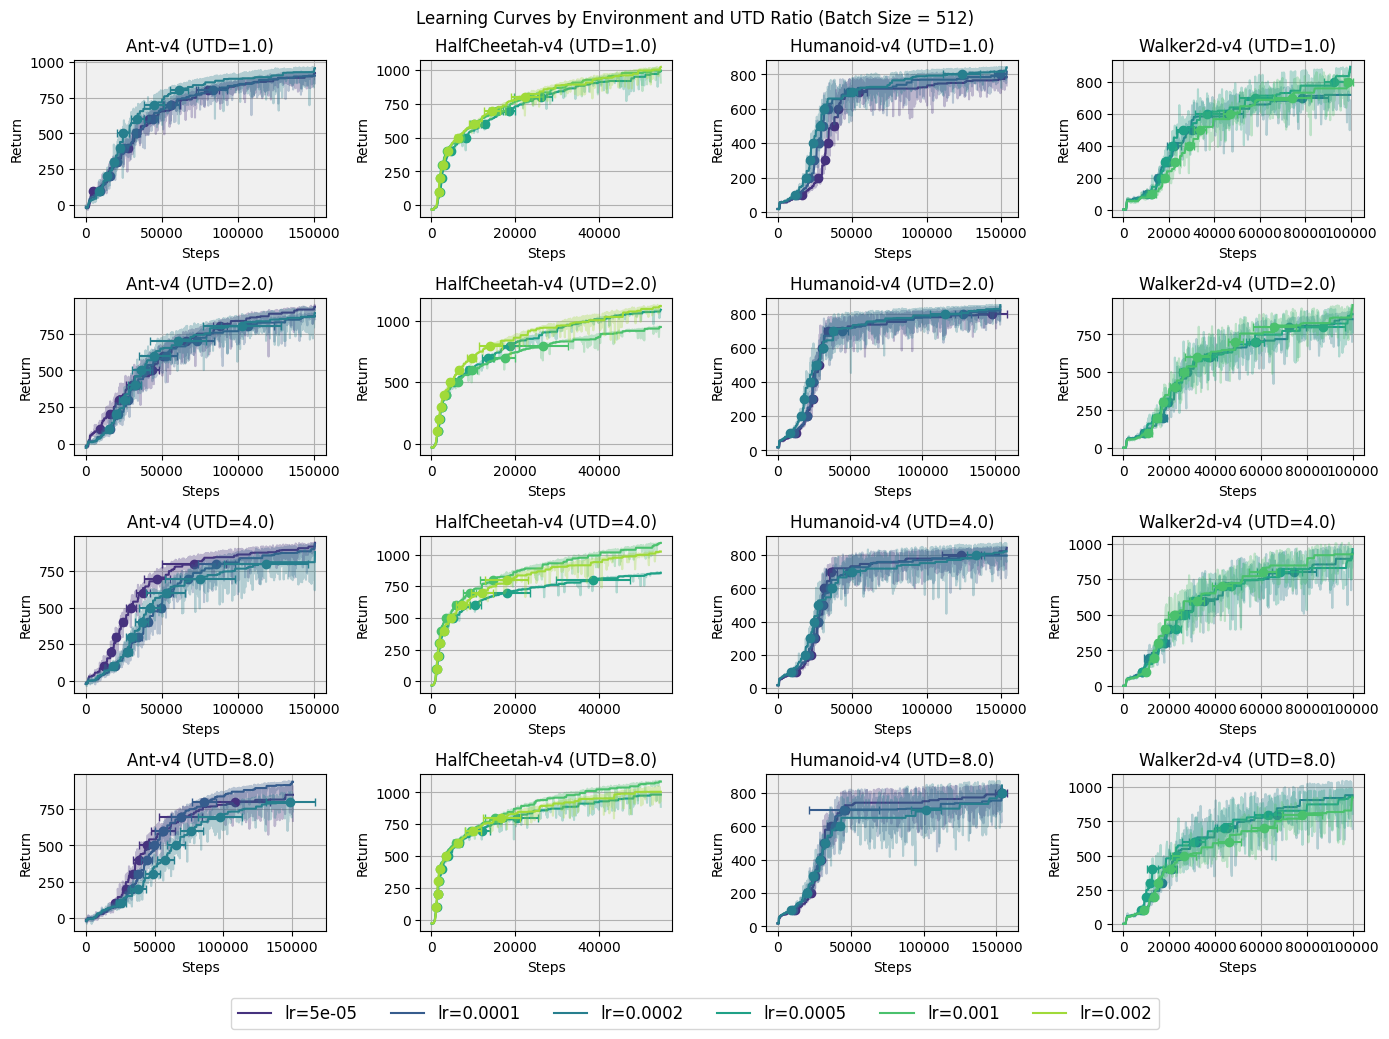

In [7]:
n_envs = len(envs)
n_utds = len(utds)

def plot_per_batch_size(df):
    for batch_size in batch_sizes:
        colors = sns.color_palette("viridis", n_colors=len(df['learning_rate'].unique()))
        fig, axs = plt.subplots(n_utds, n_envs, figsize=(3.5*n_envs, 2.5*n_utds))
        fig.suptitle(f'Learning Curves by Environment and UTD Ratio (Batch Size = {batch_size})')

        lines = []
        labels = []
        config_colors = {}
        color_idx = 0

        # Filter data for current batch size
        df_filtered = df[df['batch_size'] == batch_size]

        # Group data by environment and UTD ratio
        for i, env in enumerate(sorted(df['env_name'].unique())):
            env_data = df_filtered[df_filtered['env_name'] == env]
            
            # Create separate plots for each UTD value
            for j, utd in enumerate(sorted(env_data['utd'].unique())):
                utd_data = env_data[env_data['utd'] == utd]
                # Sort by learning rate only since we're already filtering by UTD
                utd_data = utd_data.sort_values('learning_rate')
                
                ax = axs[j, i]
                ax.set_title(f'{env} (UTD={utd})')
                
                for _, row in utd_data.iterrows():
                    config = row['learning_rate']
                    if config not in config_colors:
                        config_colors[config] = color_idx
                        color_idx += 1
                    
                    label = f"lr={row['learning_rate']}"
                    line = ax.plot(row['training_step'], row['mean_return'], alpha=0.3, color=colors[config_colors[config]])
                    line = ax.plot(row['training_step'], row['return_isotonic'], alpha=1, color=colors[config_colors[config]])
                    
                    # use the crossings column to plot crossings
                    for k, threshold in enumerate(thresholds):
                        crossing_x = row['crossings'][k]
                        crossing_y = threshold
                        ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])
                    
                    # Plot crossing standard deviations as error bars
                    for k, threshold in enumerate(thresholds):
                        crossing_x = row['crossings'][k]
                        crossing_y = threshold
                        crossing_std = row['crossings_std'][k]
                        ax.errorbar(crossing_x, crossing_y, xerr=crossing_std, fmt='none', color=colors[config_colors[config] % len(colors)], capsize=3)

                    # Only add to legend if we haven't seen this combination before
                    if label not in labels:
                        lines.append(line[0])
                        labels.append(label)
                
                ax.set_xlabel('Steps')
                ax.set_ylabel('Return')
                ax.grid(True)
                ax.set_facecolor('#f0f0f0')

        # Sort labels by learning rate
        sorted_indices = [i for i, _ in sorted(enumerate(labels), 
                                            key=lambda x: float(x[1].replace("lr=","")))]
        lines = [lines[i] for i in sorted_indices]
        labels = [labels[i] for i in sorted_indices]

        # Create a single legend outside all subplots
        fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels)), fontsize=12)
        plt.tight_layout()
        plt.show()
        

plot_per_batch_size(gym_grid_search_df)

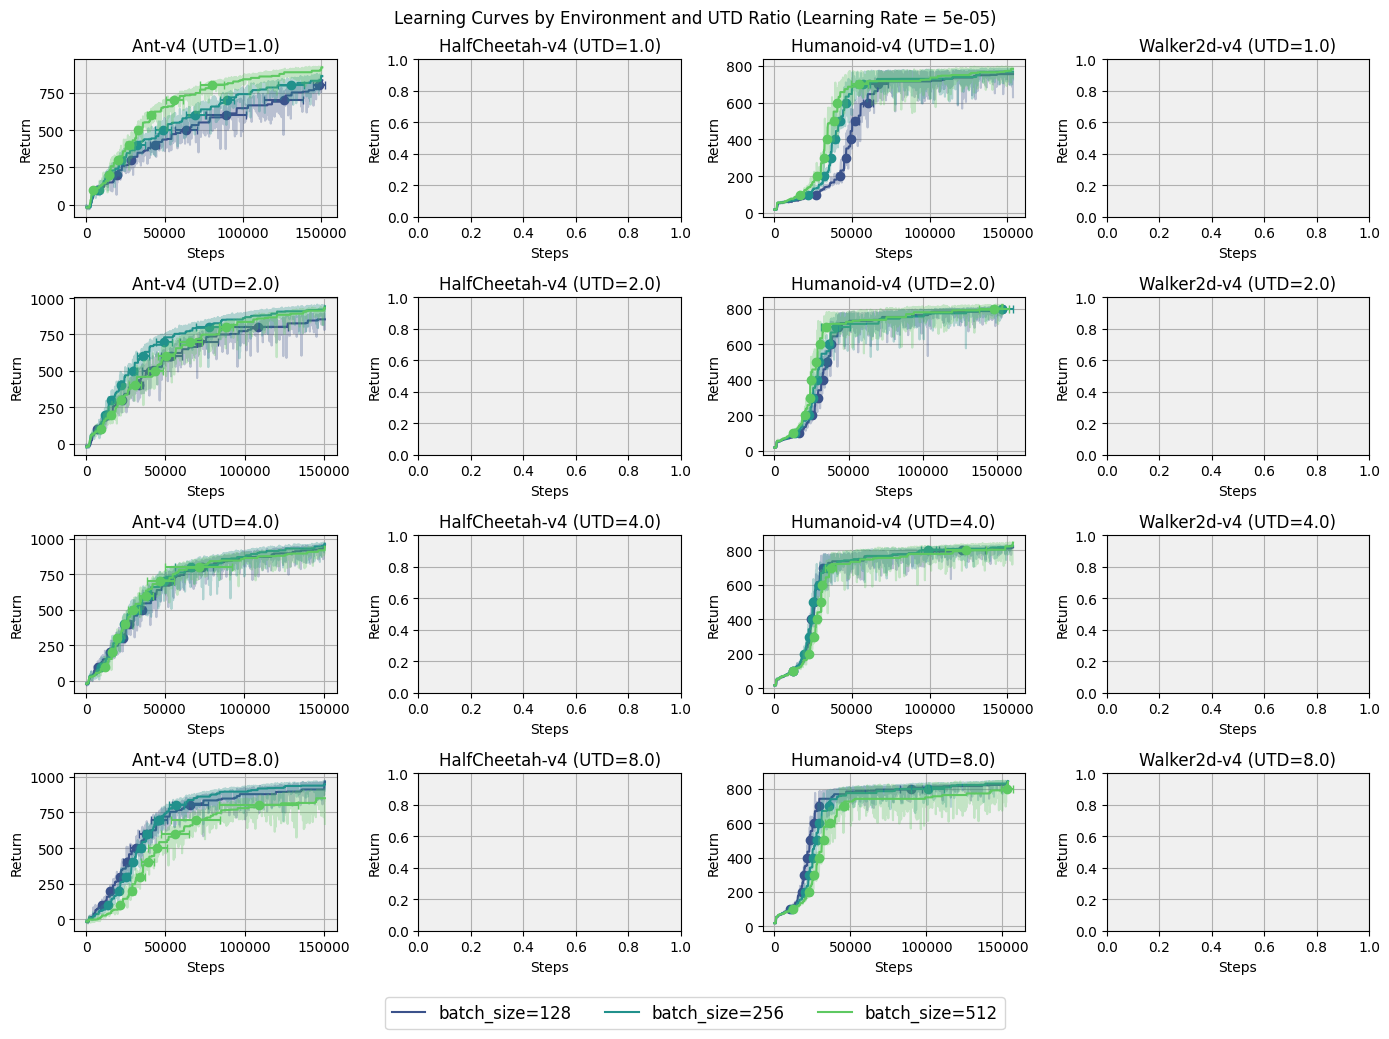

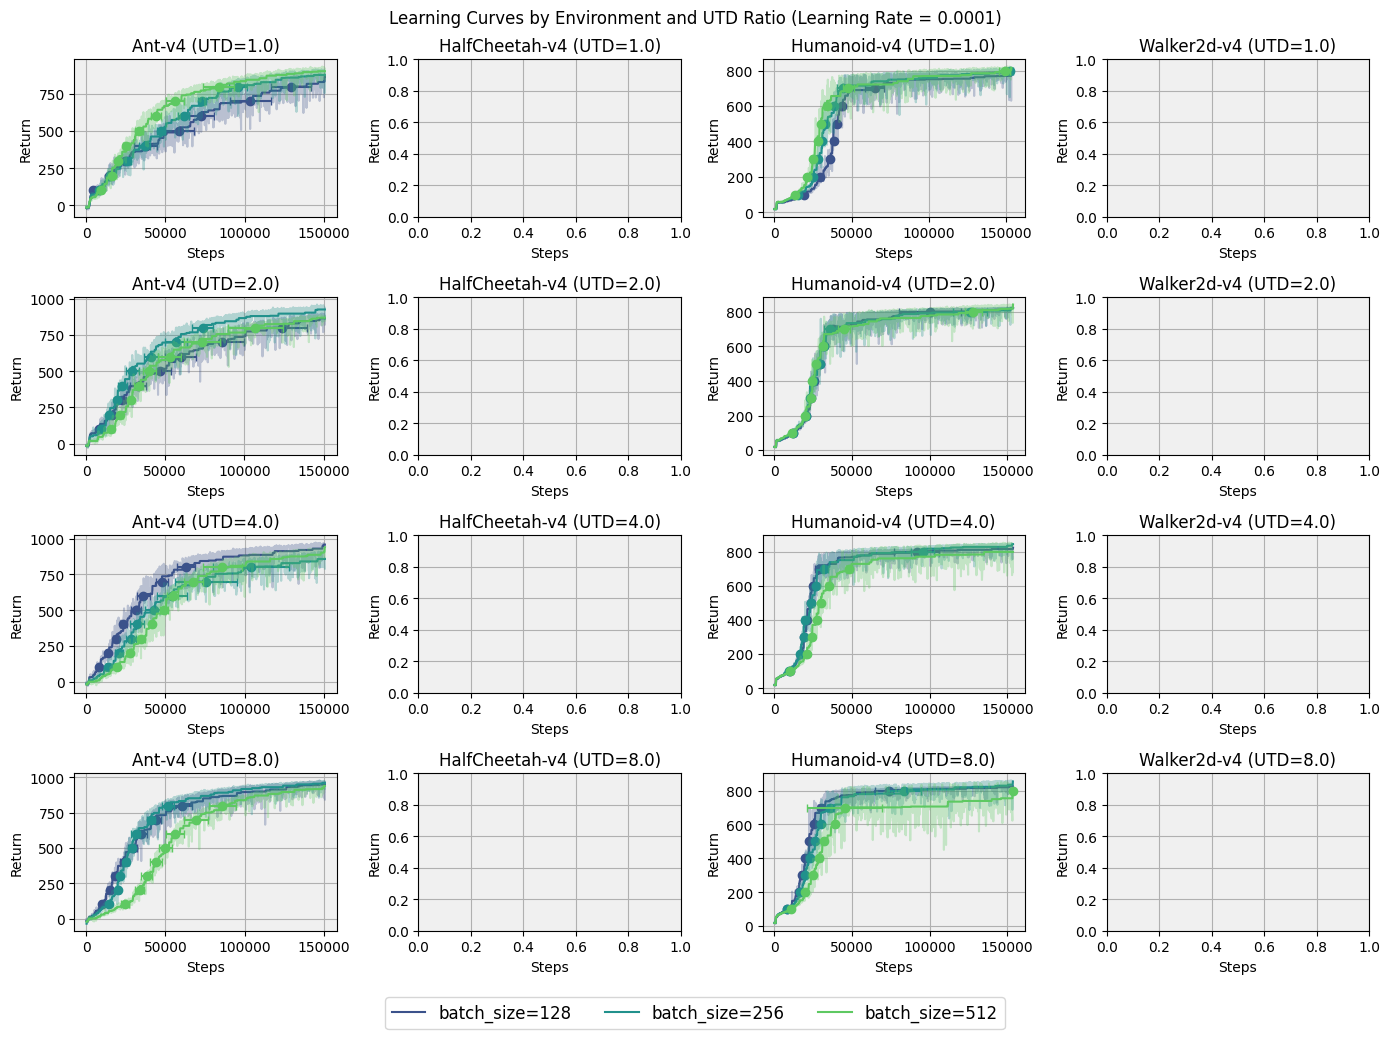

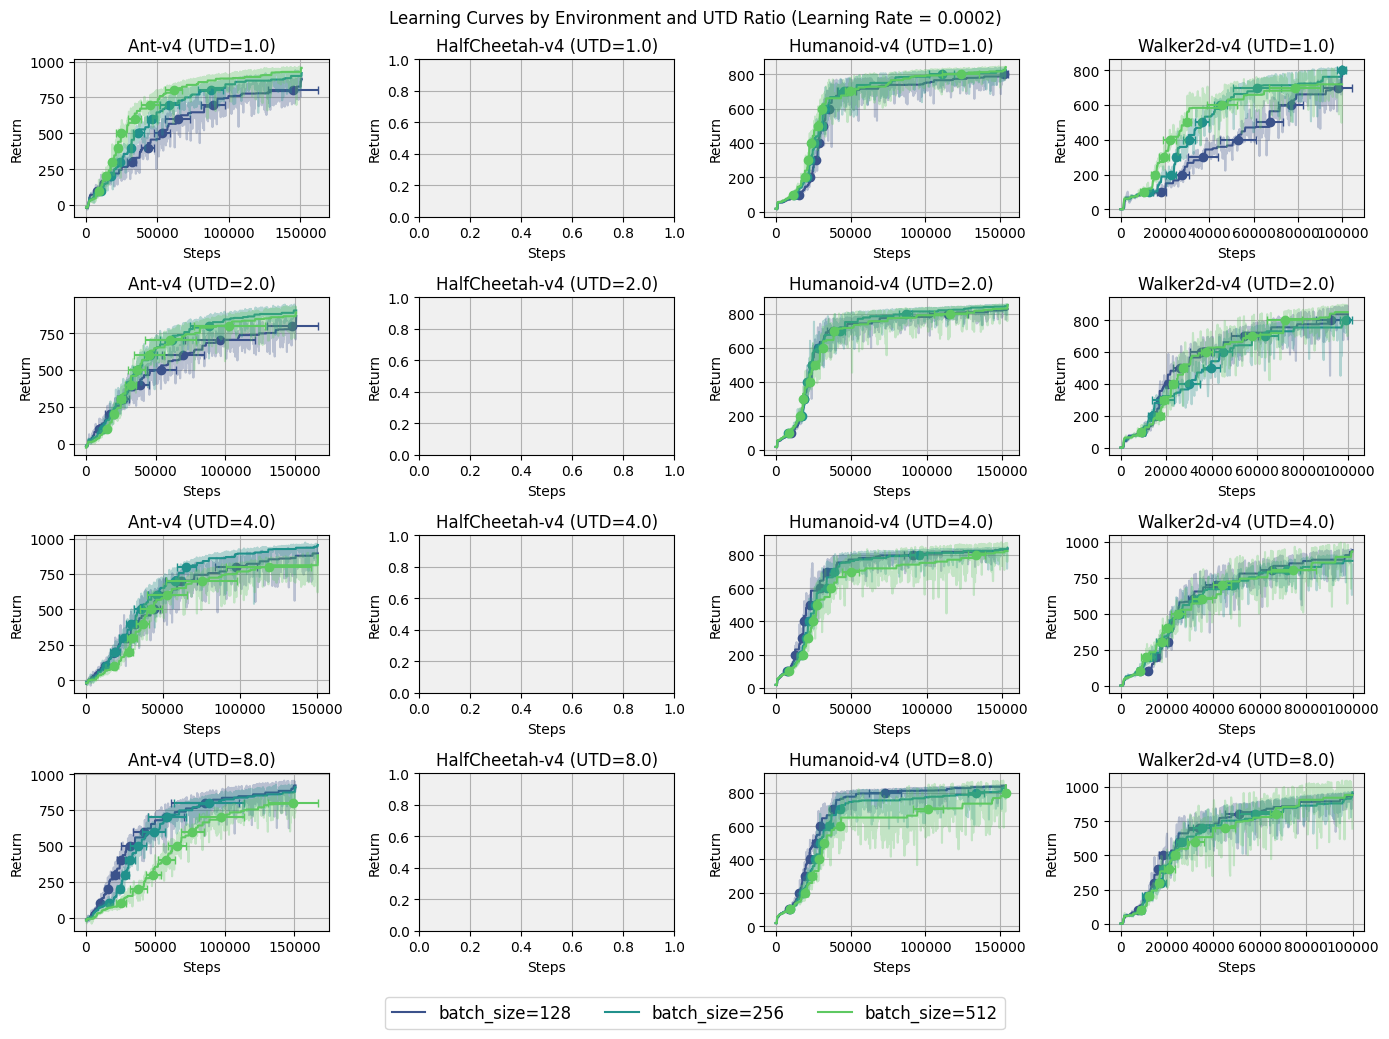

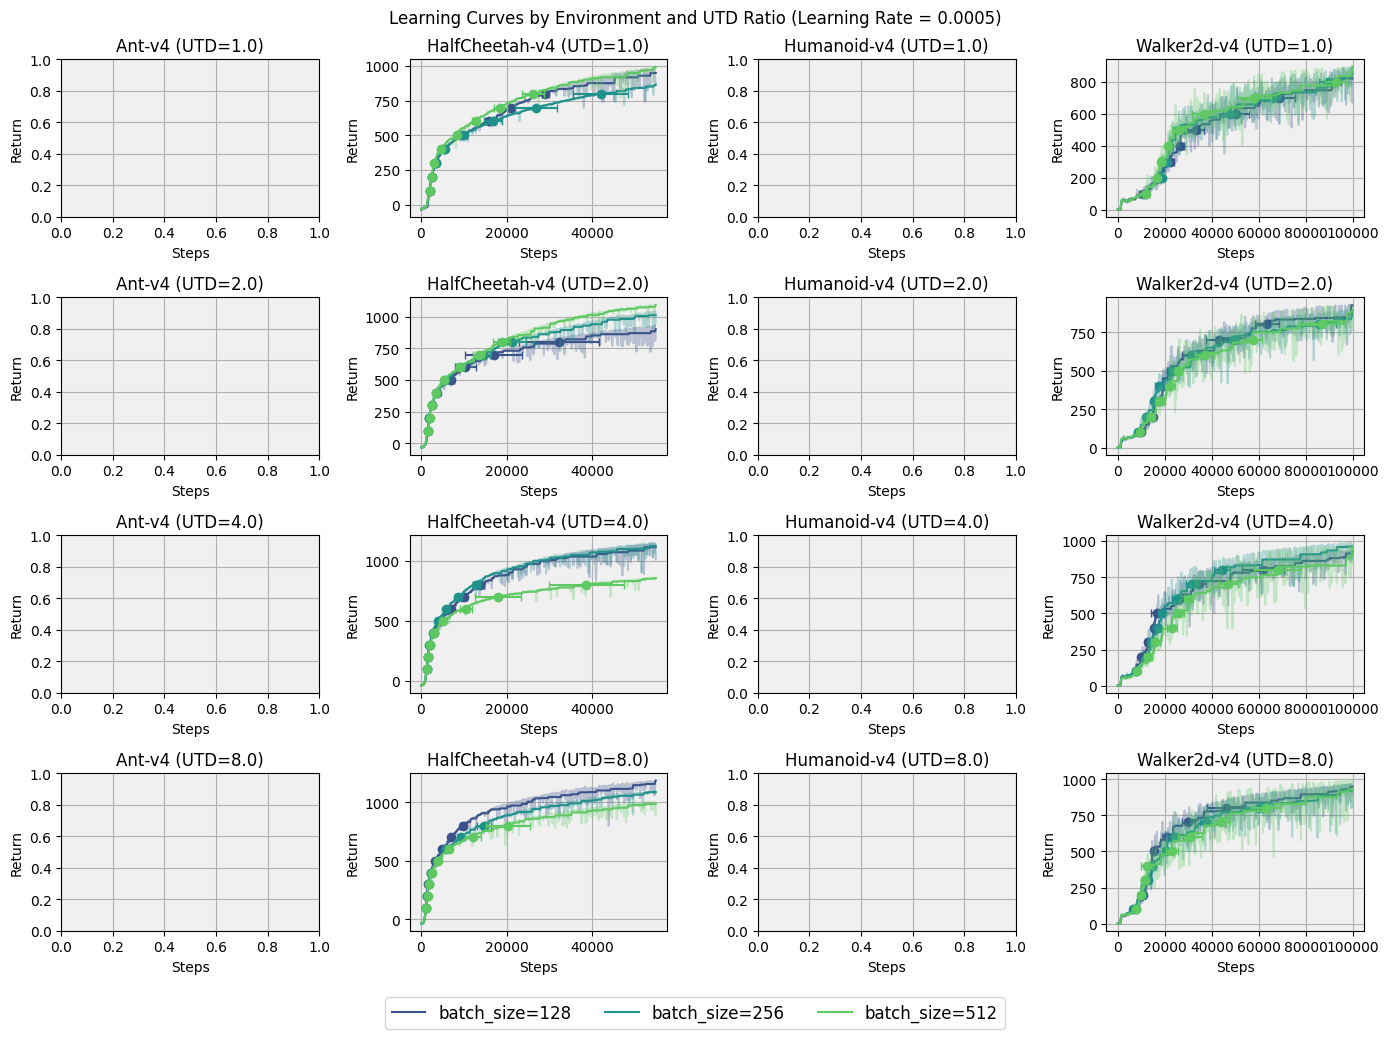

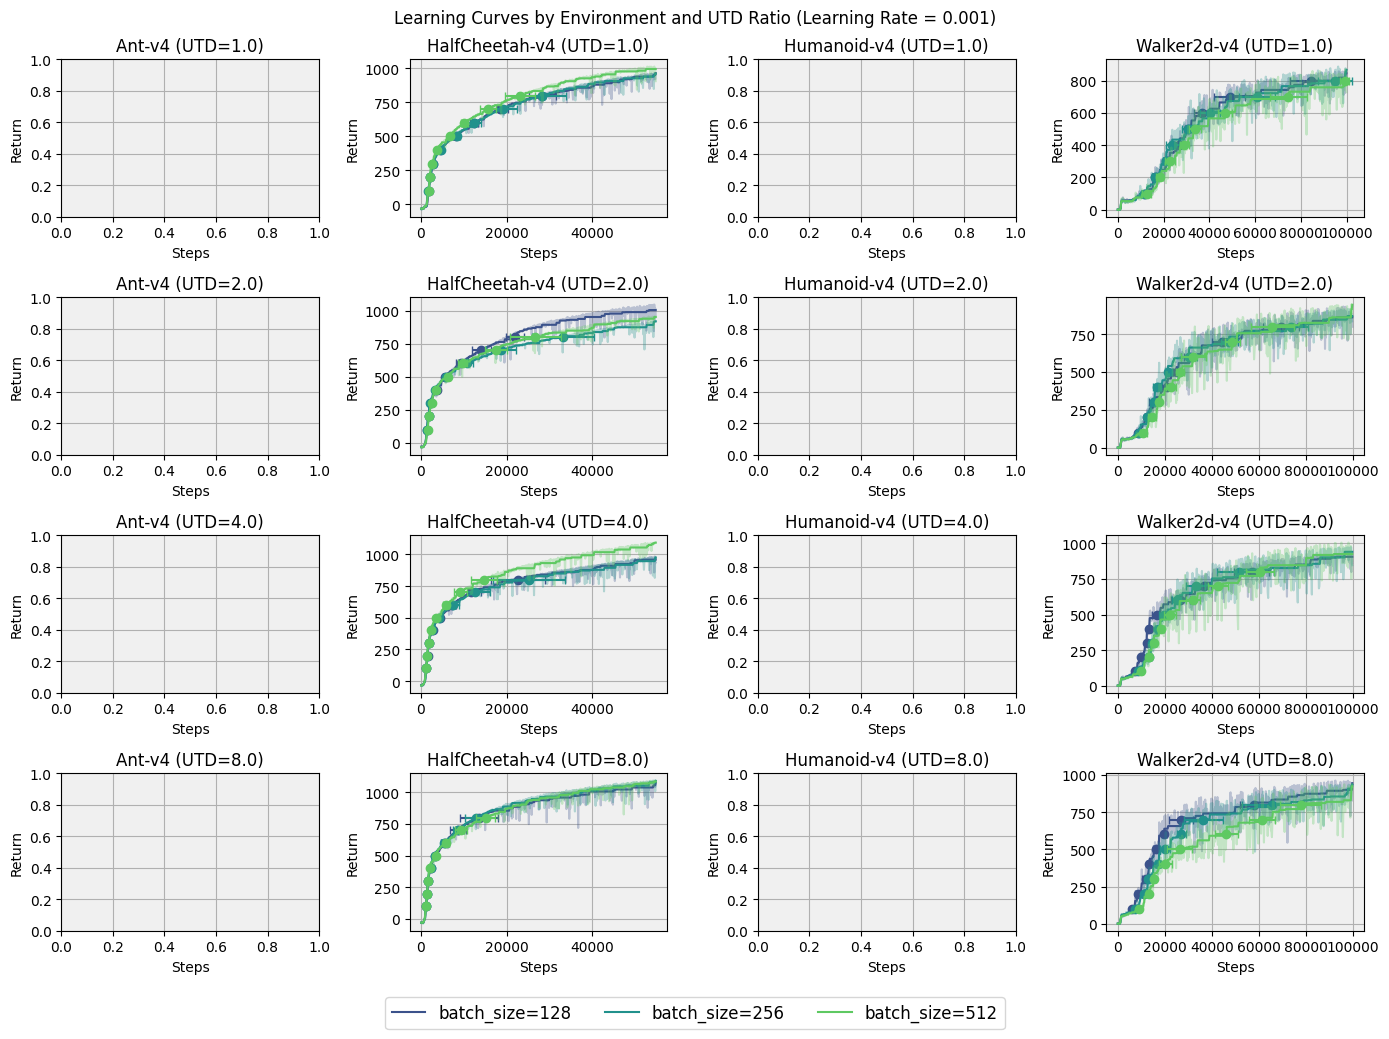

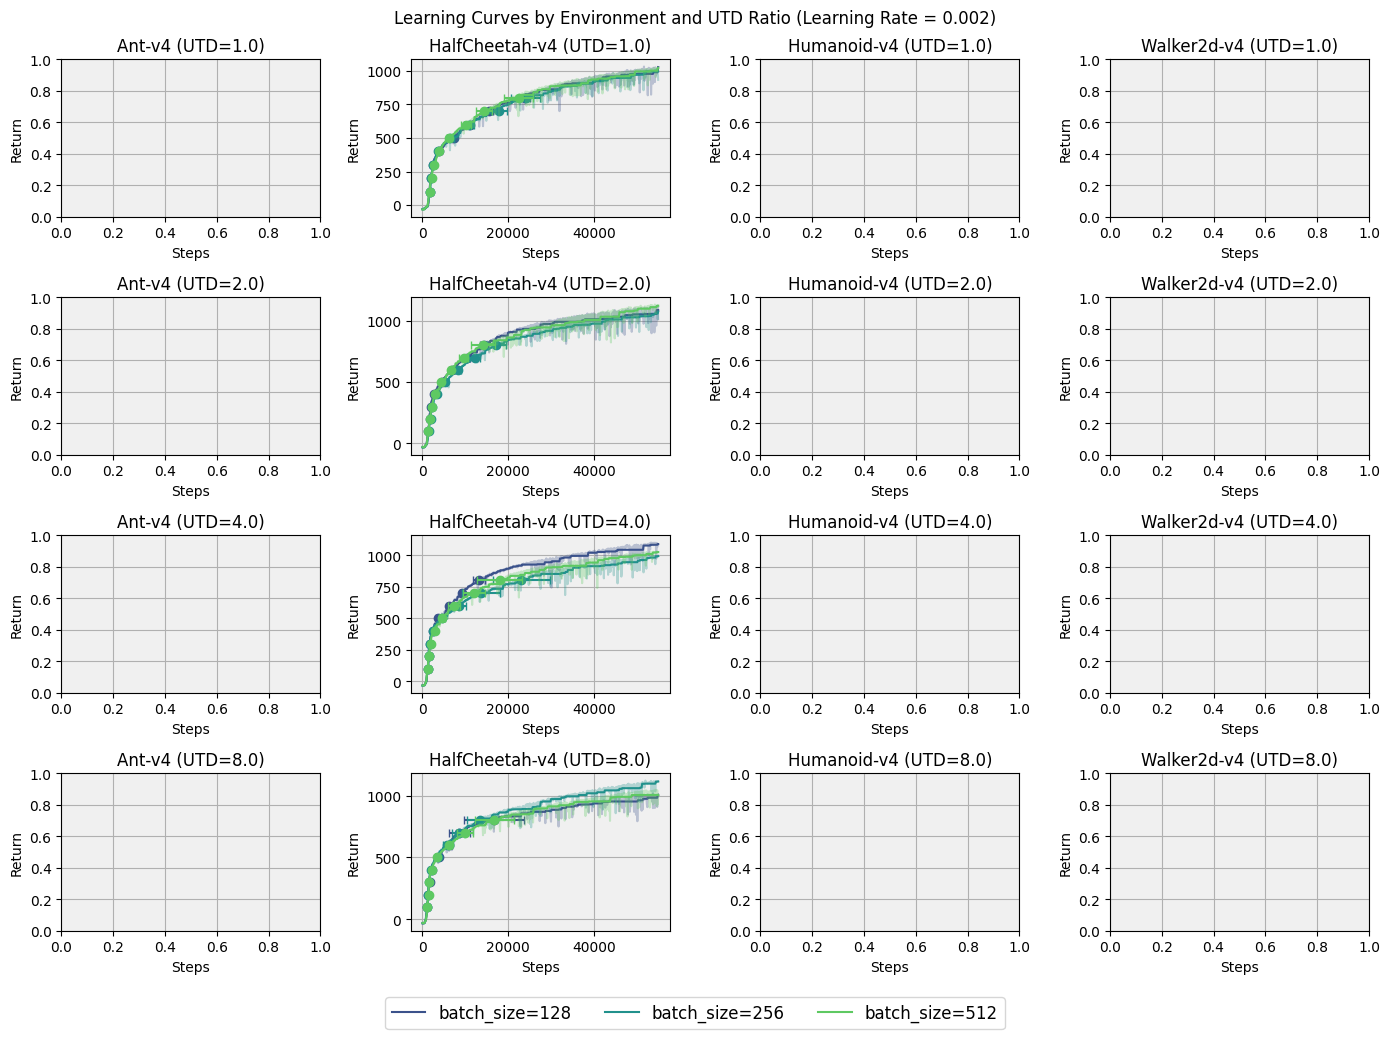

In [8]:
def plot_per_lr(df):
    for lr in sorted(learning_rates):
        colors = sns.color_palette("viridis", n_colors=len(batch_sizes))  # Using viridis for a nice gradient
        fig, axs = plt.subplots(n_utds, n_envs, figsize=(3.5*n_envs, 2.5*n_utds))
        fig.suptitle(f'Learning Curves by Environment and UTD Ratio (Learning Rate = {lr})')

        lines = []
        labels = []
        config_colors = {}
        color_idx = 0

        # Filter data for current learning rate
        df_filtered = df[df['learning_rate'] == lr]

        # Group data by environment and UTD ratio
        for i, env in enumerate(envs):
            env_data = df_filtered[df_filtered['env_name'] == env]
            
            # Create separate plots for each UTD value
            for j, utd in enumerate(sorted(df['utd'].unique())):
                utd_data = env_data[env_data['utd'] == utd]
                utd_data = utd_data.sort_values('batch_size')
                
                ax = axs[j, i]
                ax.set_title(f'{env} (UTD={utd})')
                
                for _, row in utd_data.iterrows():
                    config = row['batch_size']
                    if config not in config_colors:
                        config_colors[config] = color_idx
                        color_idx += 1
                    
                    label = f"batch_size={row['batch_size']}"
                    line = ax.plot(row['training_step'], row['mean_return'], alpha=0.3, color=colors[config_colors[config] % len(colors)])
                    line = ax.plot(row['training_step'], row['return_isotonic'], alpha=1, color=colors[config_colors[config] % len(colors)])

                    # use the crossings column to plot crossings
                    for k, threshold in enumerate(thresholds):
                        crossing_x = row['crossings'][k]
                        crossing_y = threshold
                        ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])
                        
                    # Plot crossing standard deviations as error bars
                    for k, threshold in enumerate(thresholds):
                        crossing_x = row['crossings'][k]
                        crossing_y = threshold
                        crossing_std = row['crossings_std'][k]
                        ax.errorbar(crossing_x, crossing_y, xerr=crossing_std, fmt='none', color=colors[config_colors[config] % len(colors)], capsize=3)
                    
                    # Only add to legend if we haven't seen this combination before
                    if label not in labels:
                        lines.append(line[0])
                        labels.append(label)
                
                ax.set_xlabel('Steps')
                ax.set_ylabel('Return')
                ax.grid(True)
                ax.set_facecolor('#f0f0f0')

        # Sort labels by batch size
        sorted_indices = [i for i, _ in sorted(enumerate(labels), 
                                            key=lambda x: float(x[1].replace("batch_size=","")))]
        lines = [lines[i] for i in sorted_indices]
        labels = [labels[i] for i in sorted_indices] 

        # Create a single legend outside all subplots
        fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels)), fontsize=12)
        plt.tight_layout()
        plt.show()
        

plot_per_lr(gym_grid_search_df)

# Optimal batch size and learning rate

In [9]:
def grid_best_uncertainty_lr(df):
    # make and print a table with best learning rate for each environment, batch size and UTD
    # with environment as rows and utd x batch size as columns

    # Group data by environment, batch size and UTD
    grouped = df.groupby(['env_name', 'batch_size', 'utd'])

    # Find best learning rate for each group
    results = []
    for (env, bs, utd), group in grouped:
        threshold_i = -1
        # Group by learning rate and get time to threshold
        lr_groups = group.groupby('learning_rate')
        time_to_threshold = lr_groups.apply(lambda x: x['crossings'].iloc[0][threshold_i]).dropna()
        
        # Get bootstrap samples
        time_to_threshold_bs = lr_groups.apply(lambda x: x['crossings_bootstrap'].iloc[0][:, threshold_i])
        lrs = np.array(time_to_threshold_bs.index)
        times_bs = np.array(time_to_threshold_bs.tolist())
        
        # Find best learning rates
        times_bs_inf = np.where(np.isnan(times_bs), np.inf, times_bs)
        best_lr_bootstrap = lrs[np.argmin(times_bs_inf, axis=0)]
        best_times_bootstrap = np.min(times_bs_inf, axis=0)
        
        # Get point estimates
        best_lr = time_to_threshold.idxmin() if len(time_to_threshold) > 0 else None
        min_time = time_to_threshold[best_lr] if best_lr is not None else None

        results.append({
            'env_name': env,
            'batch_size': bs,
            'utd': utd,
            'best_lr': best_lr,
            'time_to_threshold': min_time,
            'best_lr_bootstrap': best_lr_bootstrap, # run learning rate selection 100 times and record best learning rate
            'time_to_threshold_bootstrap': best_times_bootstrap, # run learning rate selection 100 times and record corresponding time to threshold
        })

    # Create DataFrame
    df_best_lr = pd.DataFrame(results)

    # Pivot table to get environments as rows and utd x batch_size as columns
    pivot_df = df_best_lr.pivot_table(
        index='utd',
        columns=['env_name', 'batch_size'],
        values='best_lr',
        aggfunc='first'
    )

    # Print formatted table with scientific notation
    pd.set_option('display.float_format', '{:.1e}'.format)
    print("\nBest Learning Rates:")
    print(pivot_df.to_string())

    # now do the same for uncertainty-corrected best learning rates
    # Create pivot table for uncertainty-corrected best learning rates
    # Use mean of bootstrap samples as uncertainty-corrected estimate
    pivot_df_bootstrap = df_best_lr.pivot_table(
        index='utd',
        columns=['env_name', 'batch_size'],
        values='best_lr_bootstrap',
        aggfunc=lambda x: np.mean(np.stack(x))
    )

    # Print formatted table with scientific notation
    print("\nUncertainty-Corrected Best Learning Rates:")
    print(pivot_df_bootstrap.to_string())
    
    return df_best_lr


gym_grid_best_lr = grid_best_uncertainty_lr(gym_grid_search_df)


Best Learning Rates:
env_name    Ant-v4                 HalfCheetah-v4                 Humanoid-v4                 Walker2d-v4                
batch_size     128     256     512            128     256     512         128     256     512         128     256     512
utd                                                                                                                      
1.0e+00    1.0e-04 2.0e-04 2.0e-04        2.0e-03 2.0e-03 2.0e-03     2.0e-04 2.0e-04 2.0e-04     1.0e-03 5.0e-04 5.0e-04
2.0e+00    5.0e-05 1.0e-04 5.0e-05        2.0e-03 2.0e-03 2.0e-03     1.0e-04 2.0e-04 2.0e-04     5.0e-04 1.0e-03 1.0e-03
4.0e+00    1.0e-04 2.0e-04 5.0e-05        2.0e-03 5.0e-04 1.0e-03     2.0e-04 2.0e-04 5.0e-05     1.0e-03 5.0e-04 1.0e-03
8.0e+00    1.0e-04 1.0e-04 1.0e-04        5.0e-04 1.0e-03 1.0e-03     2.0e-04 1.0e-04 5.0e-05     5.0e-04 2.0e-04 5.0e-04

Uncertainty-Corrected Best Learning Rates:
env_name    Ant-v4                 HalfCheetah-v4                 Humanoid-v4   

In [10]:
def grid_best_uncertainty_bs(df):
    # Find best batch size for each env/utd/lr combination based on minimum time to threshold
    best_bs_results = []
    for (env, utd, lr), group in df.groupby(['env_name', 'utd', 'learning_rate']):
        # Drop any rows where crossings[-1] is None
        group = group.dropna(subset=['crossings'])
        
        if len(group) > 0:
            # Get the last crossing time for each row and bootstrap samples
            group['last_crossing'] = group['crossings'].apply(lambda x: x[-1] if len(x) > 0 else float('inf'))
            group['last_crossing_bootstrap'] = group['crossings_bootstrap'].apply(lambda x: x[:, -1])
            
            # Get batch sizes and times for bootstrap analysis
            batch_sizes = np.array(group['batch_size'])
            times_bs = np.stack(group['last_crossing_bootstrap'])
            
            # Find best batch sizes
            times_bs_inf = np.where(np.isnan(times_bs), np.inf, times_bs)
            best_bs_bootstrap = batch_sizes[np.argmin(times_bs_inf, axis=0)]
            best_times_bootstrap = np.min(times_bs_inf, axis=0)
            
            # Get point estimates
            try:
                best_bs = group.loc[group['last_crossing'].idxmin(), 'batch_size']
                min_time = group['last_crossing'].min()
            except:
                best_bs = float('nan')
                min_time = float('inf')
            
            best_bs_results.append({
                'env_name': env,
                'utd': utd,
                'learning_rate': lr,
                'best_bs': best_bs,
                'time_to_threshold': min_time,
                'best_bs_bootstrap': best_bs_bootstrap,
                'time_to_threshold_bootstrap': best_times_bootstrap
            })

    # Create DataFrame
    df_best_bs = pd.DataFrame(best_bs_results)

    # Pivot table to show best batch sizes by environment and UTD, with learning rates as columns
    pivot_bs = df_best_bs.pivot_table(
        index=['utd'],
        columns=['env_name', 'learning_rate'],
        values='best_bs',
        aggfunc='first'
    )

    print("\nBest Batch Sizes:")
    print(pivot_bs.to_string())

    # Also show corresponding times to threshold
    pivot_times = df_best_bs.pivot_table(
        index=['utd'],
        columns=['env_name', 'learning_rate'], 
        values='time_to_threshold',
        aggfunc='first'
    )

    print("\nCorresponding Times to Threshold:")
    print(pivot_times.to_string())
    
    return df_best_bs


gym_grid_best_bs = grid_best_uncertainty_bs(gym_grid_search_df)


Best Batch Sizes:
env_name       Ant-v4                 HalfCheetah-v4                 Humanoid-v4                 Walker2d-v4                
learning_rate 5.0e-05 1.0e-04 2.0e-04        5.0e-04 1.0e-03 2.0e-03     5.0e-05 1.0e-04 2.0e-04     2.0e-04 5.0e-04 1.0e-03
utd                                                                                                                         
1.0e+00       5.1e+02 5.1e+02 5.1e+02        5.1e+02 5.1e+02 5.1e+02         NaN 5.1e+02 2.6e+02     2.6e+02 2.6e+02 1.3e+02
2.0e+00       2.6e+02 2.6e+02 2.6e+02        5.1e+02 1.3e+02 5.1e+02     5.1e+02 1.3e+02 2.6e+02     5.1e+02 1.3e+02 5.1e+02
4.0e+00       2.6e+02 1.3e+02 2.6e+02        2.6e+02 5.1e+02 1.3e+02     2.6e+02 1.3e+02 1.3e+02     1.3e+02 2.6e+02 2.6e+02
8.0e+00       2.6e+02 2.6e+02 1.3e+02        1.3e+02 2.6e+02 2.6e+02     1.3e+02 1.3e+02 1.3e+02     1.3e+02 1.3e+02 1.3e+02

Corresponding Times to Threshold:
env_name       Ant-v4                 HalfCheetah-v4                 Hu

In [11]:
def get_bootstrap_stats(group):
    """Get bootstrapped optimal batch sizes"""
    # Get time to threshold bootstrap array for all batch sizes
    batch_sizes = group['batch_size'].values
    lr_bootstrap = np.stack(group['best_lr_bootstrap'].values) # 100 bootstrap samples all have different optimal learning rates
    times_bootstrap = np.stack(group['time_to_threshold_bootstrap'].values) # 100 times to threshold corresponding to different bootstrap samples
    
    # Find optimal batch size index for each bootstrap sample
    # Replace nans with large values so they are never selected as minimum
    times_bootstrap = np.nan_to_num(times_bootstrap, nan=np.inf)
    optimal_indices_bootstrap = np.argmin(times_bootstrap, axis=0) # 100 indices of optimal batch sizes
    best_lr_bootstrap = lr_bootstrap[optimal_indices_bootstrap, np.arange(times_bootstrap.shape[1])] # for each bootstrap sample, get the learning rate corresponding to the optimal batch size
    best_times_bootstrap = times_bootstrap[optimal_indices_bootstrap, np.arange(times_bootstrap.shape[1])] # for each bootstrap sample, get the time to threshold corresponding to the optimal batch size
    best_bs_bootstrap = batch_sizes[optimal_indices_bootstrap] # for each bootstrap sample, get the optimal batch size
    
    # Get point estimate
    best_idx = group['time_to_threshold'].argmin()
    best_bs = group.iloc[best_idx]['batch_size']
    best_lr = group.iloc[best_idx]['best_lr']
    best_time = group.iloc[best_idx]['time_to_threshold']
    
    return pd.Series({
        'best_lr': best_lr,
        'best_bs': best_bs,
        'time_to_threshold': best_time,
        'best_lr_bootstrap': best_lr_bootstrap,
        'best_bs_bootstrap': best_bs_bootstrap,
        'time_to_threshold_bootstrap': best_times_bootstrap,
    })


gym_grid_best_lr_bs = gym_grid_best_lr.groupby(['env_name', 'utd']).apply(get_bootstrap_stats).reset_index()

In [12]:
def compute_averages(df_best_lr, df_best_bs, df_best_lr_bs):
    # Get bs and lr averaged across lr and bs

    for env in df_best_lr_bs['env_name'].unique():
        env_mask = df_best_lr_bs['env_name'] == env
        env_data = df_best_lr_bs[env_mask]
        
        # Calculate bootstrap mean and std for each UTD
        best_bs_bootstrap = np.stack(env_data['best_bs_bootstrap'].values)
        mean_bs_bootstrap = np.mean(best_bs_bootstrap, axis=1)
        std_bs_bootstrap = np.std(best_bs_bootstrap, axis=1)
        df_best_lr_bs.loc[env_mask, 'best_bs_bootstrap_mean'] = mean_bs_bootstrap
        df_best_lr_bs.loc[env_mask, 'best_bs_bootstrap_std'] = std_bs_bootstrap
        
        # Calculate mean and std across learning rates
        env_data_mean = df_best_bs[df_best_bs['env_name'] == env]
        utd_groups = env_data_mean.groupby('utd')
        mean_bs = utd_groups['best_bs'].mean()
        std_bs = utd_groups['best_bs'].std()
        df_best_lr_bs.loc[env_mask, 'best_bs_lrmean'] = [mean_bs[utd] for utd in env_data['utd']]
        df_best_lr_bs.loc[env_mask, 'best_bs_lrmean_std'] = [std_bs[utd] for utd in env_data['utd']]
        
        # Calculate bootstrap mean and std across learning rates
        best_bs_bootstrap = np.stack([np.stack(g['best_bs_bootstrap'].values) for _, g in utd_groups])
        mean_bs_all = np.mean(best_bs_bootstrap, axis=(1,2))
        std_bs_all = np.std(best_bs_bootstrap, axis=(1,2))
        df_best_lr_bs.loc[env_mask, 'best_bs_bootstrap_lrmean'] = [mean_bs_all[list(utd_groups.groups.keys()).index(utd)] for utd in env_data['utd']]
        df_best_lr_bs.loc[env_mask, 'best_bs_bootstrap_lrmean_std'] = [std_bs_all[list(utd_groups.groups.keys()).index(utd)] for utd in env_data['utd']]
        
        # Calculate bootstrap mean and std for each UTD
        best_lr_bootstrap = np.stack(env_data['best_lr_bootstrap'].values)
        mean_lr_bootstrap = np.mean(best_lr_bootstrap, axis=1)
        std_lr_bootstrap = np.std(best_lr_bootstrap, axis=1)
        df_best_lr_bs.loc[env_mask, 'best_lr_bootstrap_mean'] = mean_lr_bootstrap
        df_best_lr_bs.loc[env_mask, 'best_lr_bootstrap_std'] = std_lr_bootstrap
        
        # Calculate mean and std across batch sizes
        env_data_mean = df_best_lr[df_best_lr['env_name'] == env]
        utd_groups = env_data_mean.groupby('utd')
        mean_lr = utd_groups['best_lr'].mean()
        std_lr = utd_groups['best_lr'].std()
        df_best_lr_bs.loc[env_mask, 'best_lr_bsmean'] = [mean_lr[utd] for utd in env_data['utd']]
        df_best_lr_bs.loc[env_mask, 'best_lr_bsmean_std'] = [std_lr[utd] for utd in env_data['utd']]
        
        # Calculate bootstrap mean and std across batch sizes
        best_lr_bootstrap = np.stack([np.stack(g['best_lr_bootstrap'].values) for _, g in utd_groups])
        mean_lr_all = np.mean(best_lr_bootstrap, axis=(1,2))
        std_lr_all = np.std(best_lr_bootstrap, axis=(1,2))
        df_best_lr_bs.loc[env_mask, 'best_lr_bootstrap_bsmean'] = [mean_lr_all[list(utd_groups.groups.keys()).index(utd)] for utd in env_data['utd']]
        df_best_lr_bs.loc[env_mask, 'best_lr_bootstrap_bsmean_std'] = [std_lr_all[list(utd_groups.groups.keys()).index(utd)] for utd in env_data['utd']]
        
    return df_best_lr_bs


gym_grid_best_lr_bs = compute_averages(gym_grid_best_lr, gym_grid_best_bs, gym_grid_best_lr_bs)

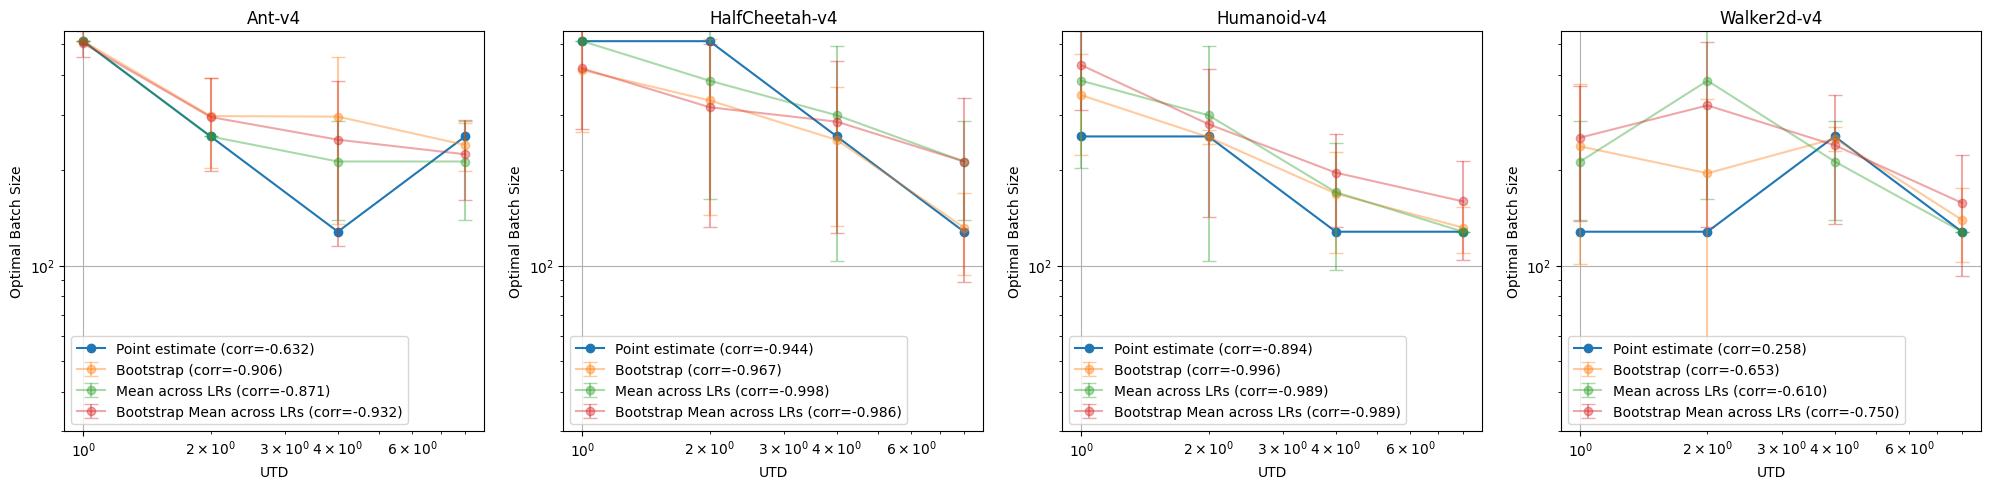

/home/preston/miniconda3/envs/crl/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/preston/miniconda3/envs/crl/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


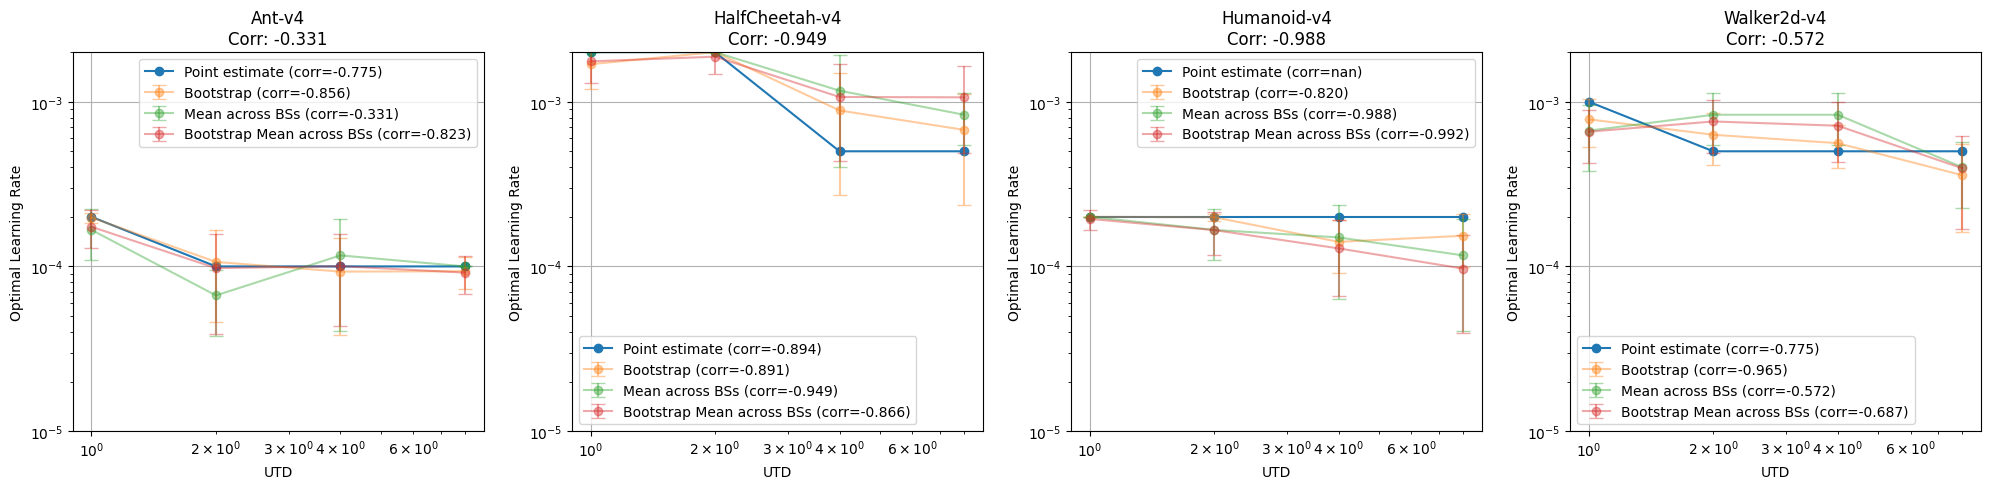

In [13]:
def plot_best_params(df_best_lr_bs):
        # plot hparams and performance for optimal bs, lr
    envs = df_best_lr_bs['env_name'].unique()
    n_envs = len(envs)

    # Create first figure for batch size plots
    n_cols = 5
    n_rows = (n_envs + n_cols - 1) // n_cols
    fig1, axs1 = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axs1 = axs1.flatten()

    # Plot 1: Optimal batch size vs UTD with bootstrap CIs and mean optimal batch size
    for i, env in enumerate(envs):
        env_data = df_best_lr_bs[df_best_lr_bs['env_name'] == env]
        
        # Calculate correlation for point estimate
        point_bs_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_bs']))[0,1]
        axs1[i].plot(env_data['utd'], env_data['best_bs'], 'o-', label=f'Point estimate (corr={point_bs_corr:.3f})')
        
        # Add bootstrapped confidence intervals
        bootstrap_bs_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_bs_bootstrap_mean']))[0,1]
        axs1[i].errorbar(env_data['utd'], env_data['best_bs_bootstrap_mean'], 
                        yerr=env_data['best_bs_bootstrap_std'],
                        fmt='o-', capsize=5, alpha=0.4,
                        label=f'Bootstrap (corr={bootstrap_bs_corr:.3f})')
        
        # Add mean optimal batch size
        bs_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_bs_lrmean']))[0,1]
        axs1[i].errorbar(env_data['utd'], env_data['best_bs_lrmean'],
                        yerr=env_data['best_bs_lrmean_std'], 
                        fmt='o-', capsize=5, alpha=0.4,
                        label=f'Mean across LRs (corr={bs_corr:.3f})')
        
        # Add mean batch size averaged across learning rates and bootstrap intervals
        bs_corr_all = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_bs_bootstrap_lrmean']))[0,1]
        axs1[i].errorbar(env_data['utd'], env_data['best_bs_bootstrap_lrmean'],
                        yerr=env_data['best_bs_bootstrap_lrmean_std'],
                        fmt='o-', capsize=5, alpha=0.4,
                        label=f'Bootstrap Mean across LRs (corr={bs_corr_all:.3f})')
        
        axs1[i].set_xscale('log')
        axs1[i].set_yscale('log')
        axs1[i].set_xlabel('UTD')
        axs1[i].set_ylim(30, 550)
        axs1[i].set_ylabel('Optimal Batch Size')
        axs1[i].set_title(f'{env}')
        axs1[i].grid(True)
        axs1[i].legend()

    # Remove empty subplots from first figure
    for j in range(i+1, len(axs1)):
        fig1.delaxes(axs1[j])

    plt.tight_layout()
    plt.show()

    # Create second figure for learning rate plots
    fig2, axs2 = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axs2 = axs2.flatten()

    # Plot 2: Optimal learning rate vs UTD with bootstrap CIs and mean optimal learning rate
    for i, env in enumerate(envs):
        env_data = df_best_lr_bs[df_best_lr_bs['env_name'] == env]
        
        # Calculate correlation for point estimate
        point_lr_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr']))[0,1]
        axs2[i].plot(env_data['utd'], env_data['best_lr'], 'o-', label=f'Point estimate (corr={point_lr_corr:.3f})')
        
        # Add bootstrapped confidence intervals
        bootstrap_lr_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr_bootstrap_mean']))[0,1]
        axs2[i].errorbar(env_data['utd'], env_data['best_lr_bootstrap_mean'],
                        yerr=env_data['best_lr_bootstrap_std'],
                        fmt='o-', capsize=5, alpha=0.4,
                        label=f'Bootstrap (corr={bootstrap_lr_corr:.3f})')
        
        # Add mean optimal learning rate
        lr_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr_bsmean']))[0,1]
        axs2[i].errorbar(env_data['utd'], env_data['best_lr_bsmean'],
                        yerr=env_data['best_lr_bsmean_std'],
                        fmt='o-', capsize=5, alpha=0.4,
                        label=f'Mean across BSs (corr={lr_corr:.3f})')
        
        # Add mean learning rate averaged across batch sizes and bootstrap intervals
        lr_corr_all = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr_bootstrap_bsmean']))[0,1]
        axs2[i].errorbar(env_data['utd'], env_data['best_lr_bootstrap_bsmean'],
                        yerr=env_data['best_lr_bootstrap_bsmean_std'],
                        fmt='o-', capsize=5, alpha=0.4,
                        label=f'Bootstrap Mean across BSs (corr={lr_corr_all:.3f})')
        
        axs2[i].set_xscale('log')
        axs2[i].set_yscale('log')
        axs2[i].set_xlabel('UTD')
        axs2[i].set_ylim(1e-5, 2e-3)
        axs2[i].set_ylabel('Optimal Learning Rate')
        axs2[i].set_title(f'{env}\nCorr: {lr_corr:.3f}')
        axs2[i].grid(True)
        axs2[i].legend()

    # Remove empty subplots from second figure
    for j in range(i+1, len(axs2)):
        fig2.delaxes(axs2[j])

    plt.tight_layout()
    plt.show()


plot_best_params(gym_grid_best_lr_bs)

Empirically, we find that using a shared slope yields better performance.

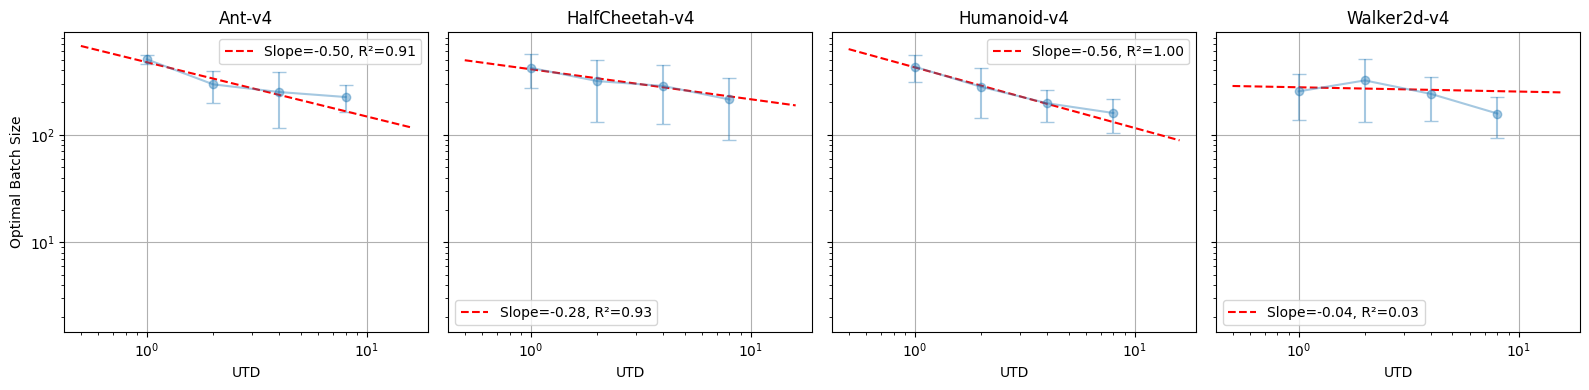

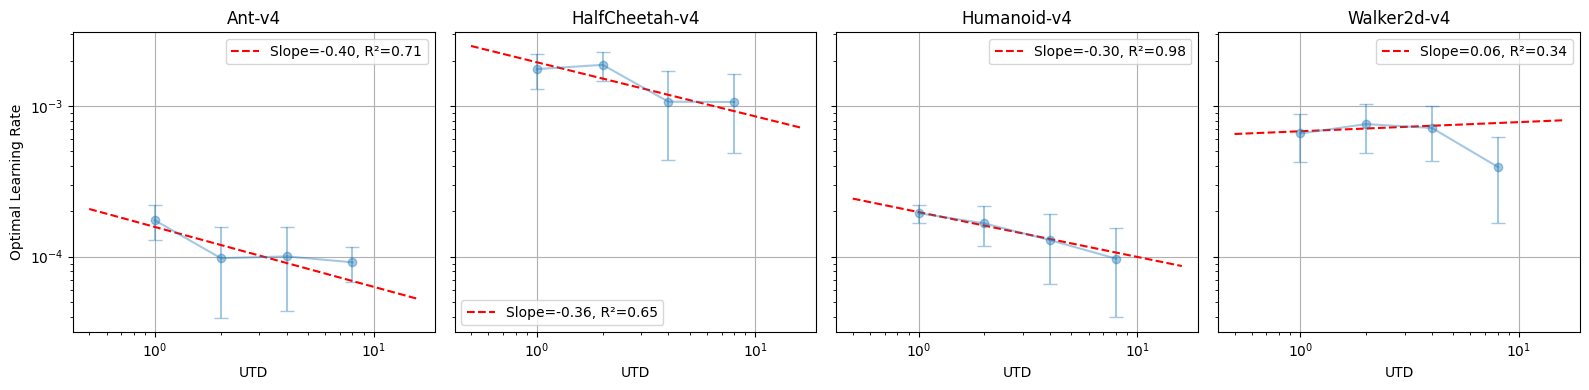

In [14]:
def plot_linear_fit_separate(df_best_lr_bs):
    # Make linear fit for bs and lr
    envs = df_best_lr_bs['env_name'].unique()
    envs = [x for x in envs if 'merged' not in x]
    n_envs = len(envs)

    # Create first figure for batch size plots
    n_cols = 4
    n_rows = (n_envs + n_cols - 1) // n_cols
    fig1, axs1 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharey=True)
    axs1 = axs1.flatten()

    # Plot 1: Optimal batch size vs UTD with bootstrap CIs and mean optimal batch size
    for i, env in enumerate(envs):
        env_data = df_best_lr_bs[df_best_lr_bs['env_name'] == env]
        
        axs1[i].errorbar(env_data['utd'], env_data['best_bs_bootstrap_lrmean'],
                        yerr=env_data['best_bs_bootstrap_lrmean_std'],
                        fmt='o-', capsize=5, alpha=0.4,)
        
        # Fit linear regression in log-log space
        X = np.log10(env_data['utd'].values[:-1]).reshape(-1, 1)
        y = np.log10(env_data['best_bs_bootstrap_lrmean'].values[:-1])
        reg = LinearRegression().fit(X, y)
        
        # Plot the fit line
        x_fit = np.array([min(env_data['utd'])*0.5, max(env_data['utd'])*2])
        y_fit = 10**(reg.predict(np.log10(x_fit).reshape(-1,1)))
        axs1[i].plot(x_fit, y_fit, '--', color='red', 
                    label=f'Slope={reg.coef_[0]:.2f}, R²={reg.score(X,y):.2f}')
        
        axs1[i].set_xscale('log')
        axs1[i].set_yscale('log')
        axs1[i].set_xlabel('UTD')
        if i == 0:
            axs1[i].set_ylabel('Optimal Batch Size')
        axs1[i].set_title(f'{env}')
        axs1[i].grid(True)
        axs1[i].legend()

    # Remove empty subplots from first figure
    for j in range(i+1, len(axs1)):
        fig1.delaxes(axs1[j])

    plt.tight_layout()
    plt.show()

    # Create second figure for learning rate plots
    fig2, axs2 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharey=True)
    axs2 = axs2.flatten()

    # Plot 2: Optimal learning rate vs UTD with bootstrap CIs and mean optimal learning rate
    for i, env in enumerate(envs):
        env_data = df_best_lr_bs[df_best_lr_bs['env_name'] == env]

        lr_corr_all = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr_bootstrap_bsmean']))[0,1]
        axs2[i].errorbar(env_data['utd'], env_data['best_lr_bootstrap_bsmean'],
                        yerr=env_data['best_lr_bootstrap_bsmean_std'],
                        fmt='o-', capsize=5, alpha=0.4,)
        
        # Fit linear regression in log-log space
        X = np.log10(env_data['utd'].values[:-1]).reshape(-1, 1)
        y = np.log10(env_data['best_lr_bootstrap_bsmean'].values[:-1])
        reg = LinearRegression().fit(X, y)
        
        # Plot the fit line
        x_fit = np.array([min(env_data['utd'])*0.5, max(env_data['utd'])*2])
        y_fit = 10**(reg.predict(np.log10(x_fit).reshape(-1,1)))
        axs2[i].plot(x_fit, y_fit, '--', color='red', 
                    label=f'Slope={reg.coef_[0]:.2f}, R²={reg.score(X,y):.2f}')
        
        axs2[i].set_xscale('log')
        axs2[i].set_yscale('log')
        axs2[i].set_xlabel('UTD')
        if i == 0:
            axs2[i].set_ylabel('Optimal Learning Rate')
        axs2[i].set_title(f'{env}')
        axs2[i].grid(True)
        axs2[i].legend()

    # Remove empty subplots from second figure
    for j in range(i+1, len(axs2)):
        fig2.delaxes(axs2[j])

    plt.tight_layout()
    plt.show()


plot_linear_fit_separate(gym_grid_best_lr_bs)

In [15]:
def fit_shared_slope_regression(df, envs, x_col='utd', y_col='best_lr_bootstrap_bsmean'):
    # Get data for all environments
    X_all = []
    y_all = []
    env_indices = []

    for i, env in enumerate(envs):
        env_data = df[df['env_name'] == env]    
        X_all.append(np.log10(env_data[x_col].values[:]))
        y_all.append(np.log10(env_data[y_col].values[:]))
        env_indices.extend([i] * len(env_data))
        
    X_all = np.concatenate(X_all).reshape(-1, 1)
    y_all = np.concatenate(y_all)
    env_indices = np.array(env_indices)

    # Create dummy variables for environment intercepts
    n_envs = len(envs)
    env_dummies = np.zeros((len(X_all), n_envs))
    for i in range(n_envs):
        env_dummies[env_indices == i, i] = 1

    # Combine UTD and environment dummies
    X_combined = np.hstack([X_all, env_dummies[:, 1:]])  # Drop first dummy to avoid collinearity

    # Fit regression
    reg_shared = LinearRegression(fit_intercept=True).fit(X_combined, y_all)

    # Extract shared slope and environment-specific intercepts
    shared_slope = reg_shared.coef_[0]
    env_intercepts = np.zeros(n_envs)
    env_intercepts[0] = reg_shared.intercept_
    env_intercepts[1:] = reg_shared.intercept_ + reg_shared.coef_[1:]
    
    return reg_shared, X_all, y_all, env_indices, n_envs, shared_slope, env_intercepts


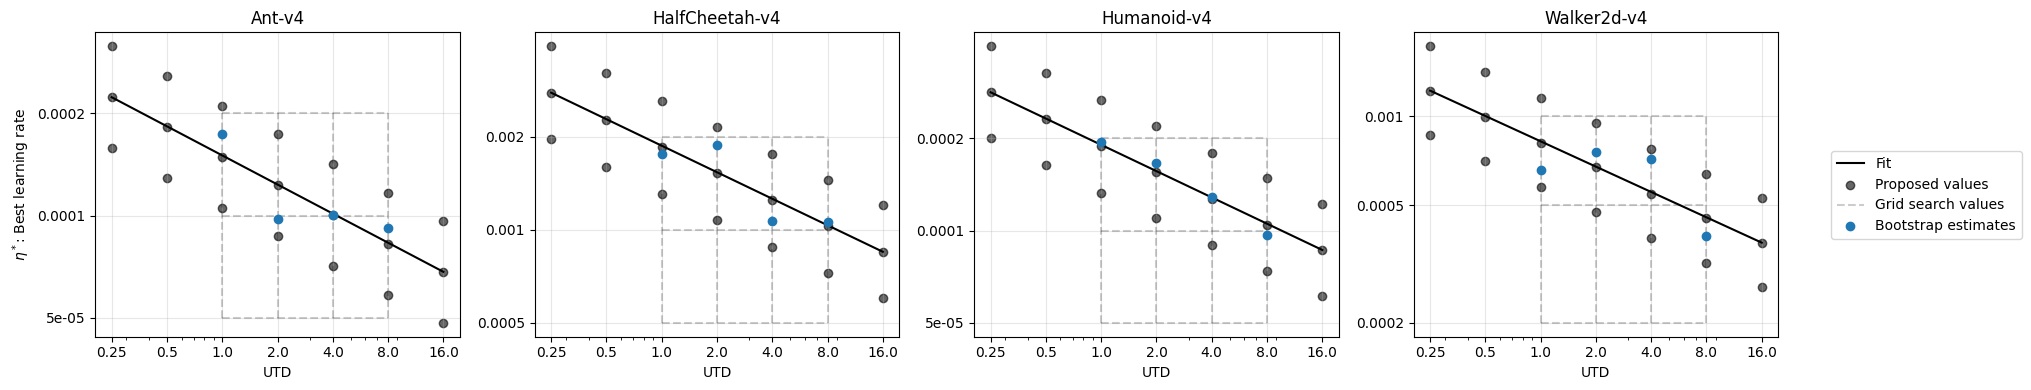

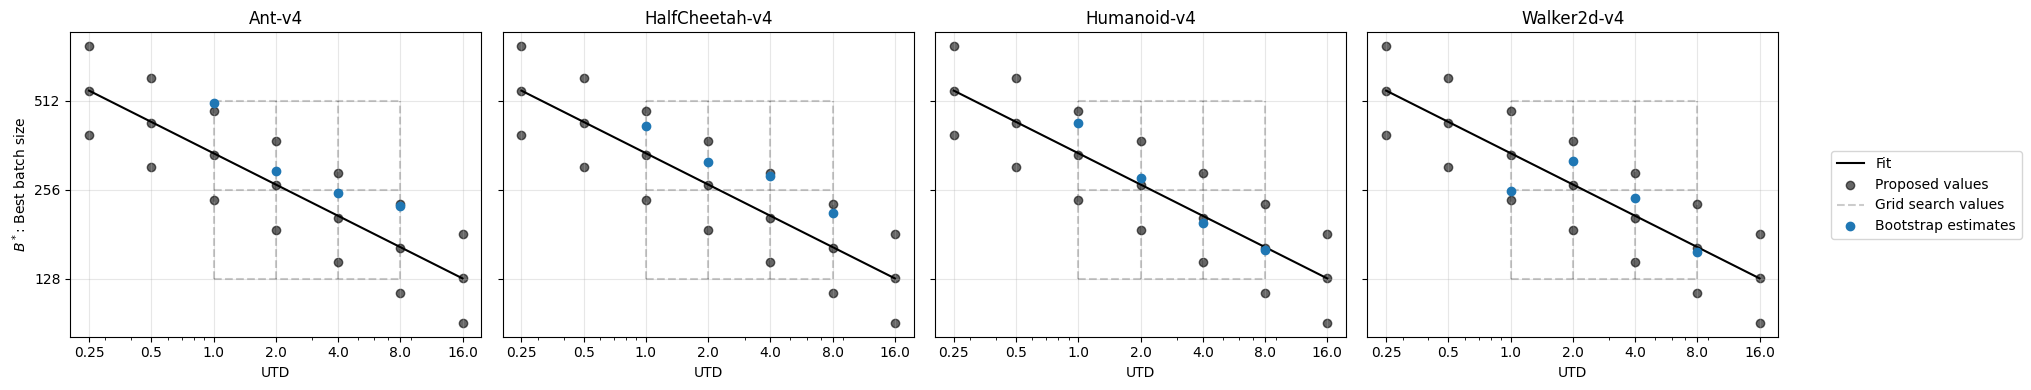

In [16]:

def plot_linear_fit_shared(predicted_utds, df, df_best_lr_bs):
    predicted_utds = np.array(predicted_utds, dtype=float)
    
    # Best learning rate fit
    reg_shared, X_all, y_all, env_indices, n_envs, _, _ = fit_shared_slope_regression(df_best_lr_bs, envs)
    
    # Create figures
    n_cols = 4
    n_rows = (n_envs + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5*n_cols, 4*n_rows), sharex=True)
    axes = axes.flatten()

    # Create table to store proposed values
    proposed_lr_values = {'Environment': [], 'UTD': [], 'Learning Rate': [], 'Learning Rate x√2': [], 'Learning Rate x√0.5': []}

    for i, env in enumerate(envs):
        mask = env_indices == i
        axes[i].errorbar(10**X_all[mask], 10**y_all[mask], yerr=None, fmt='o', capsize=5, label='Bootstrap estimates')
        
        # Get predictions
        X_plot = np.linspace(np.log10(predicted_utds.min()), np.log10(predicted_utds.max()), 100).reshape(-1, 1)
        env_dummies_plot = np.zeros((len(X_plot), n_envs-1))
        if i > 0:
            env_dummies_plot[:, i-1] = 1
        X_combined_plot = np.hstack([X_plot, env_dummies_plot])
        y_plot = reg_shared.predict(X_combined_plot)
        
        # Plot regression line
        axes[i].plot(10**X_plot, 10**y_plot, '-', color='black', label=f'Fit')
        
        # Plot data points for this environment
        utds = predicted_utds.reshape(-1, 1)
        predictions = 10**y_plot[np.searchsorted(10**X_plot.flatten(), utds)]
        
        # Store values in table
        for utd, pred in zip(utds, predictions):
            proposed_lr_values['Environment'].append(env)
            proposed_lr_values['UTD'].append(f"{utd.item():.2f}")
            proposed_lr_values['Learning Rate'].append(f"{pred.item():.2e}")
            proposed_lr_values['Learning Rate x√2'].append(f"{pred.item() * np.sqrt(2):.2e}")
            proposed_lr_values['Learning Rate x√0.5'].append(f"{pred.item() * np.sqrt(0.5):.2e}")
        
        # Plot x1.4 and x0.7 lines for each UTD point
        axes[i].scatter(utds, predictions * np.sqrt(2), marker='o', color='black', alpha=0.6, label='Proposed values')
        axes[i].scatter(utds, predictions * np.sqrt(0.5), marker='o', color='black', alpha=0.6)
        axes[i].scatter(utds, predictions, marker='o', color='black', alpha=0.6)
        
        # plot possible values of learning rate as lines
        utd_values = df[df['env_name'] == env]['utd'].unique()
        lr_values = df[df['env_name'] == env]['learning_rate'].unique()
        
        # Plot vertical lines for UTD values
        for utd in utd_values:
            axes[i].plot([utd, utd], [min(lr_values), max(lr_values)], 
                        color='black', alpha=0.2, linestyle='--',
                        label='Grid search values' if utd == utd_values[0] else None)

        # Plot horizontal lines for learning rate values
        for lr in lr_values:
            axes[i].plot([min(utd_values), max(utd_values)], [lr, lr],  
                        color='black', alpha=0.2, linestyle='--')
        
        axes[i].set_xlabel('UTD')
        axes[i].set_title(env)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].yaxis.set_major_locator(plt.FixedLocator(lr_values))
        axes[i].yaxis.set_minor_locator(plt.NullLocator()) 
        axes[i].set_xticks(predicted_utds, predicted_utds)
        axes[i].set_yticks(lr_values, lr_values)
        if i == 0:
            axes[i].set_ylabel(r'$\eta^*$: Best learning rate')

    # Create a single legend for all plots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
    plt.tight_layout()
    plt.show()
    
    
    # Best batch size fit
    reg_shared, X_all, y_all, env_indices, n_envs, _, _ = fit_shared_slope_regression(df_best_lr_bs, envs, y_col='best_bs_bootstrap_lrmean')

    # Create figures 
    n_cols = 4
    n_rows = (n_envs + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5*n_cols, 4*n_rows), sharey=True)

    # Create table to store proposed batch size values
    proposed_bs_values = {'Environment': [], 'UTD': [], 'Batch Size': [], 'Batch Size x√2': [], 'Batch Size x√0.5': []}

    for i, env in enumerate(envs):
        mask = env_indices == i
        axes[i].errorbar(10**X_all[mask], 10**y_all[mask], yerr=None, fmt='o', capsize=5, label='Bootstrap estimates')
        
        # Get predictions
        y_plot = reg_shared.predict(X_combined_plot)
        
        # Plot regression line
        axes[i].plot(10**X_plot, 10**y_plot, '-', color='black', label=f'Fit')
        
        # Plot data points for this environment
        utds = predicted_utds.reshape(-1, 1)
        predictions = 10**y_plot[np.searchsorted(10**X_plot.flatten(), utds)]
        
        # Store values in table
        for utd, pred in zip(utds, predictions):
            proposed_bs_values['Environment'].append(env)
            proposed_bs_values['UTD'].append(f"{utd.item():.2f}")
            proposed_bs_values['Batch Size'].append(f"{pred.item():.0f}")
            proposed_bs_values['Batch Size x√2'].append(f"{pred.item() * np.sqrt(2):.0f}")
            proposed_bs_values['Batch Size x√0.5'].append(f"{pred.item() * np.sqrt(0.5):.0f}")
        
        # Plot x1.4 and x0.7 lines for each UTD point
        axes[i].scatter(utds, predictions * np.sqrt(2), marker='o', color='black', alpha=0.6, label='Proposed values')
        axes[i].scatter(utds, predictions * np.sqrt(0.5), marker='o', color='black', alpha=0.6)
        axes[i].scatter(utds, predictions, marker='o', color='black', alpha=0.6)
        
        # plot possible values of batch size as lines
        utd_values = df[df['env_name'] == env]['utd'].unique()
        bs_values = df[df['env_name'] == env]['batch_size'].unique()
        
        # Plot vertical lines for UTD values
        for utd in utd_values:
            axes[i].plot([utd, utd], [min(bs_values), max(bs_values)], 
                        color='black', alpha=0.2, linestyle='--',
                        label='Grid search values' if utd == utd_values[0] else None)
        
        # Plot horizontal lines for batch size values
        for bs in bs_values:
            axes[i].plot([min(utd_values), max(utd_values)], [bs, bs],  
                        color='black', alpha=0.2, linestyle='--')
        
        axes[i].set_xlabel('UTD')
        axes[i].set_title(env)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_xticks(predicted_utds, predicted_utds)
        axes[i].yaxis.set_major_locator(plt.FixedLocator(bs_values))
        axes[i].yaxis.set_minor_locator(plt.NullLocator()) 
        axes[i].set_yticks(bs_values, bs_values)
        if i == 0:
            axes[i].set_ylabel(r'$B^*$: Best batch size')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
    plt.tight_layout()
    plt.show()
    
    return proposed_lr_values, proposed_bs_values
    
    
gym_proposed_lr_values, gym_proposed_bs_values = plot_linear_fit_shared(predicted_utds, gym_grid_search_df, gym_grid_best_lr_bs)

In [17]:
def tabulate_proposed_params(predicted_utds, proposed_lr_values, proposed_bs_values):
    predicted_utds = sorted(predicted_utds)
    
    # Display merged table of proposed values
    print("\nProposed Values:")
    print("-" * 160)
    print(f"{'Environment':<30} {'UTD':<10} {'Learning Rate':<15} {'Learning Rate x√2':<15} {'Learning Rate x√0.5':<15} {'Batch Size':<15} {'Batch Size x√2':<15} {'Batch Size x√0.5':<15}")
    print("-" * 160)

    proposed_values_formatted = []

    for env in envs:
        for utd in predicted_utds:
            utd = f'{utd:.2f}'
            # Find indices for this env/UTD combination
            lr_idx = next((i for i in range(len(proposed_lr_values['Environment'])) 
                        if proposed_lr_values['Environment'][i] == env and proposed_lr_values['UTD'][i] == utd), None)
            bs_idx = next((i for i in range(len(proposed_bs_values['Environment'])) 
                        if proposed_bs_values['Environment'][i] == env and proposed_bs_values['UTD'][i] == utd), None)
            
            if lr_idx is not None and bs_idx is not None:
                print(f"{env:<30} {utd:<10} "
                    f"{proposed_lr_values['Learning Rate'][lr_idx]:<15} "
                    f"{proposed_lr_values['Learning Rate x√2'][lr_idx]:<15} "
                    f"{proposed_lr_values['Learning Rate x√0.5'][lr_idx]:<15} "
                    f"{proposed_bs_values['Batch Size'][bs_idx]:<15} "
                    f"{proposed_bs_values['Batch Size x√2'][bs_idx]:<15} "
                    f"{proposed_bs_values['Batch Size x√0.5'][bs_idx]:<15}")
                
                proposed_values_formatted.append({
                    'Environment': env,
                    'UTD': utd,
                    'Learning Rate': proposed_lr_values['Learning Rate'][lr_idx],
                    'Learning Rate x√2': proposed_lr_values['Learning Rate x√2'][lr_idx],
                    'Learning Rate x√0.5': proposed_lr_values['Learning Rate x√0.5'][lr_idx],
                    'Batch Size': proposed_bs_values['Batch Size'][bs_idx],
                    'Batch Size x√2': proposed_bs_values['Batch Size x√2'][bs_idx],
                    'Batch Size x√0.5': proposed_bs_values['Batch Size x√0.5'][bs_idx],
                })
    proposed_values_df = pd.DataFrame(proposed_values_formatted).astype(
        {
            "Environment": str,
            "UTD": float,
            "Learning Rate": float,
            "Learning Rate x√2": float,
            "Learning Rate x√0.5": float,
            "Batch Size": int,
            "Batch Size x√2": int,
            "Batch Size x√0.5": int,
        }
    )

    for c in proposed_values_df.columns:
        if 'Batch Size' in c:
            proposed_values_df[f'{c}(rounded)'] = (np.round(proposed_values_df[c] / 16) * 16).astype(int)

    outfile = f'data/grid_proposed_hparams/{path}_fitted.csv'
    os.makedirs(os.path.dirname(outfile), exist_ok=True)
    proposed_values_df.to_csv(outfile, index=False)
    return proposed_values_df


gym_proposed_values_df = tabulate_proposed_params(predicted_utds, gym_proposed_lr_values, gym_proposed_bs_values)


Proposed Values:
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Environment                    UTD        Learning Rate   Learning Rate x√2 Learning Rate x√0.5 Batch Size      Batch Size x√2  Batch Size x√0.5
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Ant-v4                         0.25       2.23e-04        3.16e-04        1.58e-04        554             783             392            
Ant-v4                         0.50       1.82e-04        2.58e-04        1.29e-04        431             609             305            
Ant-v4                         1.00       1.49e-04        2.10e-04        1.05e-04        335             474             237            
Ant-v4                         2.00       1.23e-04        1.73e-04        8.67e-05        264        

In [ ]:
def tabulate_baseline_params(df, predicted_utds):
    """
    For a fixed UTD (geometric mean among predicted UTDs), find the best
    (batch size, learning rate) pair. Then run this across many UTDs. The
    output csv details additional experiments to be run.
    """
    middle_utd = np.prod(predicted_utds) ** (1/len(predicted_utds))  # Geometric mean of predicted UTDs
    snap_utd = min(utds, key=lambda x: abs(np.log(x) - np.log(middle_utd)))  # Snap to nearest UTD in grid search
    print('Baseline based on UTD', snap_utd)
    
    utd_data = df[df['utd'] == snap_utd]
    utd_data['last_crossing'] = utd_data['crossings'].apply(lambda x: x[-1])
    idx = utd_data.groupby(['env_name'])['last_crossing'].idxmin()
    baseline_values_df = utd_data.loc[idx]
    
    res_dict = {}
    for _, row in baseline_values_df.iterrows():
        res_dict[row['env_name']] = {'batch_size': row['batch_size'], 'learning_rate': row['learning_rate']}
    
    baseline_values_df['utd'] = [predicted_utds] * n_envs
    baseline_values_df = baseline_values_df.explode('utd').reset_index(drop=True)
    baseline_values_df = baseline_values_df[['env_name', 'utd', 'learning_rate', 'batch_size']].rename(columns={
        'env_name': 'Environment', 
        'utd': 'UTD', 
        'learning_rate': 'Learning Rate', 
        'batch_size': 'Batch Size'
    })
    display(baseline_values_df)

    out_dir = 'data/grid_proposed_hparams'
    os.makedirs(out_dir, exist_ok=True)
    # baseline_values_df.query(f'UTD in {utds}').to_csv(f'{out_dir}/{path}_baseline_utd{snap_utd}_existing.csv', index=False)
    baseline_values_df.query(f'UTD not in {utds}').to_csv(f'{out_dir}/{path}_baseline_utd{snap_utd}_new.csv', index=False)
    
    return res_dict, snap_utd


gym_baseline_values_dict, baseline_snap_utd = tabulate_baseline_params(gym_grid_search_df, predicted_utds)

Baseline based on UTD 2.0


/tmp/ipykernel_1882089/4220107582.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utd_data['last_crossing'] = utd_data['crossings'].apply(lambda x: x[-1])


Environment     UTD  Learning Rate  Batch Size
0           Ant-v4 2.5e-01        1.0e-04         256
1           Ant-v4 5.0e-01        1.0e-04         256
2           Ant-v4       1        1.0e-04         256
3           Ant-v4       2        1.0e-04         256
4           Ant-v4       4        1.0e-04         256
5           Ant-v4       8        1.0e-04         256
6           Ant-v4      16        1.0e-04         256
7   HalfCheetah-v4 2.5e-01        2.0e-03         512
8   HalfCheetah-v4 5.0e-01        2.0e-03         512
9   HalfCheetah-v4       1        2.0e-03         512
10  HalfCheetah-v4       2        2.0e-03         512
11  HalfCheetah-v4       4        2.0e-03         512
12  HalfCheetah-v4       8        2.0e-03         512
13  HalfCheetah-v4      16        2.0e-03         512
14     Humanoid-v4 2.5e-01        2.0e-04         256
15     Humanoid-v4 5.0e-01        2.0e-04         256
16     Humanoid-v4       1        2.0e-04         256
17     Humanoid-v4       2        2.0e-04         256
18     Humanoid-v4       4        2.0e-04         256
19     Humanoid-v4       8        2.0e-04         256
20     Humanoid-v4      16        2.0e-04         256
21     Walker2d-v4 2.5e-01        5.0e-04         128
22     Walker2d-v4 5.0e-01        5.0e-04         128
23     Walker2d-v4       1        5.0e-04         128
24     Walker2d-v4       2        5.0e-04         128
25     Walker2d-v4       4        5.0e-04         128
26     Walker2d-v4       8        5.0e-04         128
27     Walker2d-v4      16        5.0e-04         128

In [50]:
def update_baseline_tags(new_tag):
    """Tag existing runs with the baseline batch size and learning rate in Wandb."""
    new_tag_collector = CRLRunCollector(wandb_project)
    assert all(cat in new_tag_collector.categories for cat in ['env', 'batch_size', 'learning_rate'])
    for env, hparams in gym_baseline_values_dict.items():
        new_tag_collector.add_tag(tags=wandb_tags, new_tag=new_tag, parallel=True, env=env, **hparams)
    
if wandb_collect and wandb_update_baseline_tag:
    new_tag = f'{wandb_update_baseline_tag}_utd{baseline_snap_utd}'
    print(f'Updating baseline tags with new tag: {new_tag}')
    update_baseline_tags(new_tag)

Updating baseline tags with new tag: sac_grid_250207_bl_utd2.0


1583it [00:07, 218.03it/s]                          
1583it [00:00, 468037.73it/s]           
1583it [00:00, 504757.73it/s]           
1583it [00:00, 469593.55it/s]           
